In [69]:
from PIL import Image
import pandas as pd

# Voetbalcompetitie met Monte Carlo

Dit zijn de meegeleverde kansen.

Uitleg ("how to read"): De drie getallen in een veld geven de win-/gelijkspel-/verlieskans aan voor de thuisspelende partij (voor de uitspelende partij is winst en verlies natuurlijk omgedraaid). Bijv. voor de wedstrijd Ajax - PSV, zoek de rij van Ajax in de linkerkolom (thuisspelende partij) en daarbij de juiste kolom met PSV als uitspelend: 54/21/25. Deze waarden betekenen op een volgende dat: de thuisspelende partij (Ajax dus) met 54% kans gaat winnen, met 21% kans gelijk speelt of met 25% kans verliest van de uitspelende partij (PSV dus).

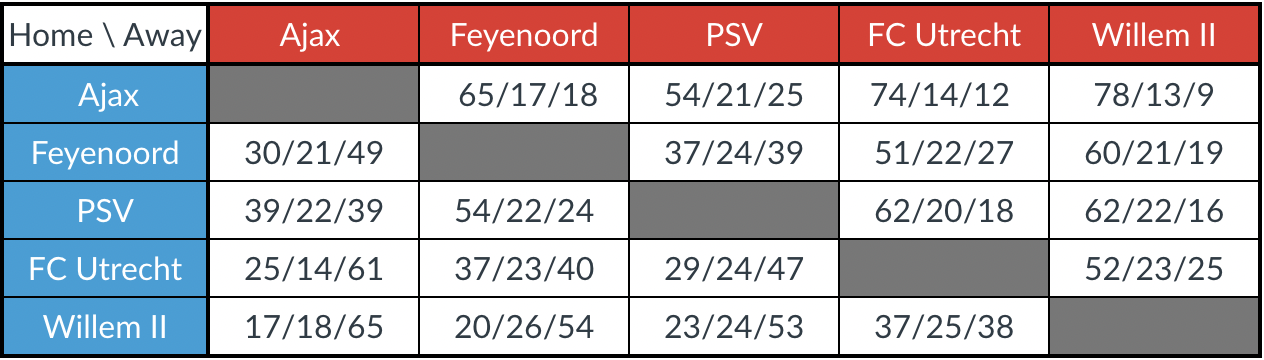

In [70]:
display(Image.open('images/Screenshot 2021-12-17 at 10.31.43.png'))

In [71]:
def draw_randomness(rng, normalizer = 1):
    img = Image.new('1', (200, 200))
    pixels = img.load()
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            random_number = rng.next() / normalizer # TODO: replace with RNG call
            pixels[x, y] = 0 if random_number < 0.5 else 1
    return img

## De opdracht

Eerst worden er een aantal RNG's gemaakt vervolgens zal de simulatie gemaakt worden.

### RNG
Er zullen een aantal RNG's aangeleverd worden met ieder z'n voor en nadelen.

#### Middle square

In [72]:
def select_middle(number, positions):
    left = True
    while len(str(number)) > positions:
        if left:
            number = int(str(number)[1:])
            left = False
        else:
            number = int(str(number)[:-1])
            left = True
    return number


class MidSquareGen:
    def __init__(self, seed):
        self.seed = seed

    def reset(self, seed):
        self.seed = seed

    def next(self):
        self.seed = select_middle(self.seed**2, 4)
        return self.seed / 10000.0

In [73]:
middle_square = MidSquareGen(12345)

Voor het valideren van de rng ga ik 2 technieken gebruiken.
Dit is de eerste, hierbij word op basis van de resultaten van de rng een afbeelding getekend. In deze afbeelding zou je patronen kunnen herkennen op het moment dat de rng niet random is. Zoals hieronder, hier kan je zo'n patroon zien dit is de afbeelding met de random numbers van de middel square generator.

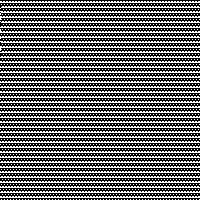

In [74]:
display(draw_randomness(middle_square))

Ook heb ik de Pseudorandom Number Sequence Test Program uitgevoerd hieronder de resultaten.

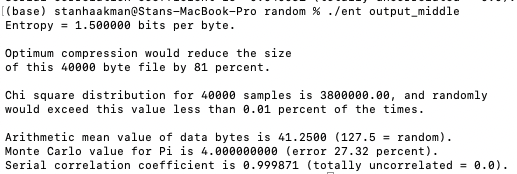

In [75]:
display(Image.open('images/Entropy_Middle.png'))

#### LCG

In [76]:
class LCG:
    def __init__(self, seed, a, b, m):
        self.seed = seed
        self.a = a
        self.b = b
        self.m = m

    def change_seed(self, seed):
        self.seed = seed

    def next(self):
        self.seed = (self.a * self.seed + self.b) % self.m
        return self.seed

In [77]:
mod = 2**14
lcg = LCG(1, 544321, 121245, mod)

Voor het valideren van de rng ga ik 2 technieken gebruiken. Dit is de eerste, hierbij word op basis van de resultaten van de rng een afbeelding getekend. In deze afbeelding zou je patronen kunnen herkennen op het moment dat de rng niet random is. Bij de vorige was een duidelijk patroon te zien maar bij deze RNG is dit al veel minder bij deze generator.

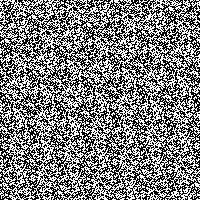

In [78]:
display(draw_randomness(lcg, mod))

Ook heb ik de Pseudorandom Number Sequence Test Program uitgevoerd hieronder de resultaten.

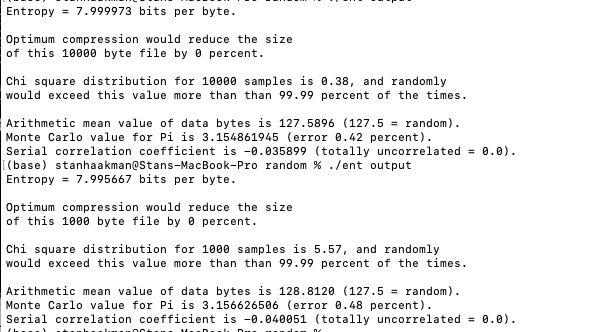

In [79]:
display(Image.open('images/Entropy_LCG.png'))

#### LFG
Deze rng ben ik helaas niet meer helemaal aan toe gekomen maar ik laat hem er wel in staan zodat ik hier later mee verder kan werken.

In [80]:
class LFG:
    def __init__(self, seed, j, k):
        self.seed = seed
        self.j = j
        self.k = k

    def generate_list(self):
        print(self.lagfib(self.seed))

    def next(self, n):
        return self.lagfib(n - self.j) + self.lagfib(n - self.k) % 2**32

### Monte Carlo Simulatie
Eerst maak ik een panda's dataframe met de win/gelijk/verlies kansen.

In [81]:
odds = pd.read_csv('odds.csv', names = ['Ajax', 'Feyenoord', 'PSV', 'FC Utrecht', 'Willem II'])
odds

,Ajax,Feyenoord,PSV,FC Utrecht,Willem II
Ajax,/,65/17/18,54/21/25,74/14/12,78/13/9
Feyenoord,30/21/49,/,37/24/39,51/22/27,60/21/19
PSV,39/22/39,54/22/24,/,62/20/18,62/22/16
FC Utrecht,25/14/61,37/23/40,29/24/47,/,52/23/25
Willem II,17/18/65,20/26/54,23/24/53,37/25/38,/


Vervolgens maak ik een helper functie die gebruikt gaat worden voor het berekenen van een win. Hierin word een random nummer gegenereerd en vervolgens word bepaald of er gewonnen, verloren of gelijkspel is. Vervolgens word het punten aantal terug gestuurd.

In [82]:
def calc_win(odd, rng, devider=1):
    odd = odd.split('/')
    odd = [int(x) / 100 for x in odd if x != '']
    random_number = rng.next() / devider

    if random_number <= odd[0]:
        # Gewonnen == 0
        # print("Gewonnen")
        return 3
    elif odd[0] < random_number <= odd[1]:
        # Gelijkspel == 1
        # print("Gelijkspel")
        return 1
    else:
        # Verloren == 0
        # print("Verloren")
        return 0

Hier word een competitie uitgespeeld hierin worden alle teams tegen elkaar opgezet en een eindstand bepaald

In [83]:
def competitie(rng, modulo=1):
    score = {
        "Ajax": 0,
        "Feyenoord": 0,
        "FC Utrecht": 0,
        "Willem II": 0,
        "PSV": 0
    }

    for home_team, values in odds.iterrows():
        for away_team, chance in values.iteritems():
            if chance != '/':
                punten = calc_win(chance, rng, modulo)

                # Punten toewijzen
                score[home_team] += punten

                # Bij gelijkspel beide teams een punt
                if punten == 1:
                    score[away_team] += punten

    return score

In [84]:
print([competitie(lcg, mod) for i in range(1)])

[{'Ajax': 6, 'Feyenoord': 6, 'FC Utrecht': 0, 'Willem II': 3, 'PSV': 9}]


Hier word de competitie een x aantal keer uitgevoerd en vervolgens de percentages van het eindresultaat getoont.

In [85]:
def get_win_chances(n, rng, modulo=1):

    result = pd.DataFrame(0, columns = ['1st pos', '2nd pos', '3rd pos', '4th pos', '5th pos'], index = ['Ajax', 'Feyenoord', 'PSV', 'FC Utrecht', 'Willem II'])

    positions = ['1st pos', '2nd pos', '3rd pos', '4th pos', '5th pos']

    for _ in range(n):
        results_comp = competitie(rng, modulo)

        # Sort the dictionary
        results_comp = {k: v for k, v in sorted(results_comp.items(), key = lambda item: item[1], reverse = True)}

        last_points = 0
        skip = False
        x = 0

        for team, points in results_comp.items():

            result[positions[x]].loc[team] = result[positions[x]].loc[team] + 1


            if last_points == points:
                skip = True
                continue

            last_points = points

            if skip:
                x += 2
                skip = False
            else:
                x += 1

    percent_tabel = result.div(result.sum(axis=1), axis=0).mul(100).round(2)
    percent_tabel = percent_tabel.astype('string').add('%')

    return percent_tabel

resultaat = get_win_chances(1000, lcg, mod)

In [86]:
resultaat

,1st pos,2nd pos,3rd pos,4th pos,5th pos
Ajax,68.0%,25.6%,4.2%,2.0%,0.2%
Feyenoord,13.4%,48.0%,25.7%,10.9%,2.0%
PSV,13.8%,37.5%,27.7%,15.5%,5.5%
FC Utrecht,4.2%,30.6%,27.7%,28.8%,8.7%
Willem II,0.6%,15.9%,21.2%,34.4%,27.9%
